In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns
from scipy.interpolate import interp1d
import glob
import re

In [3]:


def get_avg_intensities(filename):
    plate_data = pd.read_excel(filename)
    averages = []
    groups = [['A','B'],['D','E']]
    
    for i, g in enumerate(groups):
        if i == 0:
            for column in range(2,13):
                row_values = []
                for row in g:
                    row_values.append(float(plate_data[f'{row}{column}']))
                averages.append(np.mean(row_values))
                
        else:
            for column in range(1,4):
                row_values = []
                for row in g:
                    row_values.append(float(plate_data[f'{row}{column}']))
                averages.append(np.mean(row_values))
                    
    
    return list(np.array(averages)/max(averages))



In [4]:
# model = frac = 1/1+e**-(dGh20 + m*gdm)/RT
R = 0.001987   # Kcal right now. 0.0083 for kjoules
T = 298



def model_fraction(params,gdm,R,T):
    return 1/(1+np.exp(-(params[0]+(params[1]*gdm))/(R*T)))

def residuals(params,gdm,R,T,obs):
    return model_fraction(params,gdm,R,T) - obs




In [9]:
compiled_data = {}

for file in glob.iglob('gdm_stability_replicate/*_stability.xlsx'):
    concentrations = [i for i in np.arange(0.25,6.5,0.5)]
    
    
    concentrations2 = [i for i in np.arange(0.5,7,0.5)]
    
    split_name = file.split('\\')
    
    genotype = split_name[1][:split_name[1].index('_')]
    
    if 'UVH62Q' not in genotype:
        replicate = get_avg_intensities(f'gdm_stability/{genotype}_stability.xlsx')[1:]

    
        if 'UV' in genotype:
            avg_data = get_avg_intensities(file)[1:]
            color = 'red'
            color2 = 'maroon'
            label = ' + UV'

        else:
            avg_data = get_avg_intensities(file)[1:]
            color='green'
            color2 = 'springgreen'
            label = ' - UV'

        all_conc = np.array(concentrations+concentrations2)
        all_avg_data = np.array(avg_data+replicate)

        idx = np.argsort(all_conc)
        all_conc = all_conc[idx]
        all_avg_data = all_avg_data[idx]

    
        res = least_squares(residuals,[0.3,1],args=[all_conc,R,T,all_avg_data])

        intercept, slope = res.x

        theoretical = model_fraction([intercept,slope],np.linspace(0.25,6.5,100),R,T)

        cM = -intercept/slope
 
    else:
        all_avg_data = np.array(get_avg_intensities(file)[1:])
        all_conc = np.array(concentrations)
        
        res = least_squares(residuals,[0.3,1],args=[all_conc,R,T,all_avg_data])
        intercept, slope = res.x

        theoretical = model_fraction([intercept,slope],np.linspace(0.25,6.5,100),R,T)

        cM = -intercept/slope
    print(genotype,slope)
        
    compiled_data[genotype] = {'conc':all_conc,'intensities':all_avg_data,'fit_x':np.linspace(0.25,6.5,100),'fit_y':theoretical,
                              'cm':cM}

A69T -0.7612831692075959
Anc15 -1.5081293986571567
GFP -0.5079920665587306
H62Q -1.0338782810839349
Q62H -0.4840527004986677
T69A -0.5612652091683873
UVA69T -1.5069238719297753
UVAnc15 -2.038764030206998
UVGFP -0.5092342670518949
UVH62Qsecond -1.09919153460091
UVH62Q -1.136551579954681
UVQ62H -0.4929610110163632
UVT69A -0.5463356683970757


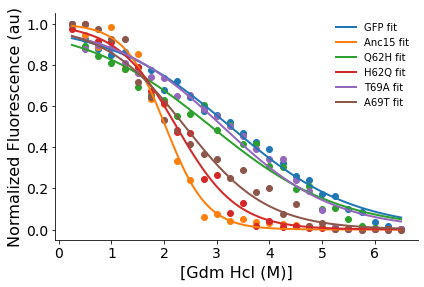

In [5]:
gens = ['GFP','Anc15','Q62H','H62Q','T69A','A69T']
fig,ax = plt.subplots()
for g in gens:
    #if g == 'T69A':
    ax.scatter(compiled_data[g]['conc'],compiled_data[g]['intensities'])
    #ax.scatter(compiled_data[f'UV{g}']['conc'],compiled_data[f'UV{g}']['intensities'],color='magenta',label=f'{g} + UV')

    ax.plot(compiled_data[g]['fit_x'],compiled_data[g]['fit_y'],label=f'{g} fit',linewidth=2)

    #ax.plot(compiled_data[f'UV{g}']['fit_x'],compiled_data[f'UV{g}']['fit_y'],color='purple',label=f'fit {g} + UV')

    ax.legend(frameon=False)

    ax.set_ylim(-0.05,1.05)
    #ax.text(x=2.5,y=0.5,s=f'cM = {np.round(compiled_data[f"{g}"]["cm"],2)}',fontsize=14,color="gray")
    #ax.text(x=4.5,y=0.4,s=f'cM = {np.round(compiled_data[f"UV{g}"]["cm"],2)}',fontsize=11,color="purple")

    ax.tick_params(axis='both',labelsize=14)

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

    ax.set_xlabel('[Gdm Hcl (M)]',fontsize=16)
    ax.set_ylabel('Normalized Fluorescence (au)', fontsize=16)



    # Extra stuff
    #ax.axhline(y=0.5,xmin=0,xmax=0.33,color='gray',alpha=0.5,linestyle='--')
    #ax.axvline(x=2.24,ymin=0,ymax=0.5,color='gray',alpha=0.5,linestyle='--')

    #ax.annotate("", xy=(3.5, 0.492), xytext=(2.27, 0.492),
     #   arrowprops=dict(width=4,headwidth=7,headlength=5,facecolor='gray',edgecolor='black'))

    #ax.annotate("", xy=(1.1, 0.492), xytext=(2.19, 0.492),
     #   arrowprops=dict(width=4,headwidth=7,headlength=5,facecolor='gray',edgecolor='black'))

    #ax.text(x=0.2,y=0.54,s='Less stable',fontsize=13)
    #ax.text(x=3.,y=0.54,s='More stable',fontsize=13)

    plt.tight_layout()

    #plt.savefig(f'../library_patterns/Final_figures/Summary_stability/raw_fits_with_points.pdf')

In [8]:
# cm's used in scatter plot of figure 7B

for g in gens:
    print(g,compiled_data[g]['cm'])

GFP 3.2568395391174128
Anc15 2.029006189878832
Q62H 2.8950260497154168
H62Q 2.235901949314924
T69A 3.1132926027482446
A69T 2.399352204489652
